In [ ]:
# Import libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import json
from datetime import datetime
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, RepeatVector, TimeDistributed, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f" TensorFlow version: {tf.__version__}")
print("f GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")
print(f" All libraries imported successfully")

✅ TensorFlow version: 2.19.0
✅ GPU available: False
✅ All libraries imported successfully


In [ ]:
# Mount Google Drive to access client weights
from google.colab import drive

drive.mount('/content/drive')

# Configuration
DRIVE_BASE = '/content/drive/MyDrive/federated_learning'
ROUND_NUM = 1  # Current federated learning round
SERVER_OUTPUT = f'{DRIVE_BASE}/server'

os.makedirs(SERVER_OUTPUT, exist_ok=True)

print(f" Google Drive mounted successfully")
print(f" Federated learning path: {DRIVE_BASE}")
print(f" Server output path: {SERVER_OUTPUT}")
print(f" Round: {ROUND_NUM}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted successfully
📁 Federated learning path: /content/drive/MyDrive/federated_learning
📁 Server output path: /content/drive/MyDrive/federated_learning/server
🔄 Round: 1


In [ ]:
# Upload Server Training Data
from google.colab import files

print(" Please upload the server's CAN data file :")
uploaded = files.upload()

if uploaded:
    print(f" File uploaded successfully: {list(uploaded.keys())[0]}")
else:
    print(" No file uploaded")

📂 Please upload the server's CAN data file (safe_ev_can_data.xlsx):


Saving server_data.xlsx to server_data.xlsx
✅ File uploaded successfully: server_data.xlsx


In [ ]:
# Model Architecture Definition (Must match client architecture)

def build_lstm_autoencoder(seq_length, n_features, latent_dim=48, activation='tanh',
                          dropout_rate=0, learning_rate=0.000602358853272268):
    """Build LSTM autoencoder with 3 hidden layers - SAME AS CLIENT"""
    layer1_units = 64
    layer2_units = 58
    layer3_units = latent_dim

    inputs = Input(shape=(seq_length, n_features), name='can_input')

    # ENCODER
    encoder = LSTM(layer1_units, activation=activation, return_sequences=True, name='encoder_lstm_1')(inputs)
    if dropout_rate > 0:
        encoder = Dropout(dropout_rate, name='encoder_dropout_1')(encoder)

    encoder = LSTM(layer2_units, activation=activation, return_sequences=True, name='encoder_lstm_2')(encoder)
    if dropout_rate > 0:
        encoder = Dropout(dropout_rate, name='encoder_dropout_2')(encoder)

    encoded = LSTM(layer3_units, activation=activation, return_sequences=False, name='encoder_lstm_3')(encoder)

    # DECODER
    decoder = RepeatVector(seq_length, name='repeat_vector')(encoded)
    decoder = LSTM(layer3_units, activation=activation, return_sequences=True, name='decoder_lstm_1')(decoder)
    if dropout_rate > 0:
        decoder = Dropout(dropout_rate, name='decoder_dropout_1')(decoder)

    decoder = LSTM(layer2_units, activation=activation, return_sequences=True, name='decoder_lstm_2')(decoder)
    if dropout_rate > 0:
        decoder = Dropout(dropout_rate, name='decoder_dropout_2')(decoder)

    decoder = LSTM(layer1_units, activation=activation, return_sequences=True, name='decoder_lstm_3')(decoder)
    outputs = TimeDistributed(Dense(n_features), name='decoder_output')(decoder)

    model = Model(inputs=inputs, outputs=outputs, name='lstm_autoencoder_3layers')
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])

    return model

print(" Model architecture defined (matches client architecture)")

✅ Model architecture defined (matches client architecture)


In [ ]:
# Federated Weight Aggregation Functions

def load_client_weights(client_id, round_num, base_path=DRIVE_BASE):
    """Load weights from a specific client"""
    weights_file = f"{base_path}/round_{round_num}/client_{client_id}_weights.npz"

    if not os.path.exists(weights_file):
        print(f" Weights file not found: {weights_file}")
        return None

    loaded_weights = np.load(weights_file)
    weights = [loaded_weights[f'arr_{i}'] for i in range(len(loaded_weights.files))]

    print(f" Loaded {len(weights)} weight arrays from Client {client_id}")
    return weights

def aggregate_weights(client_weights_list, aggregation_method='fedavg'):
    """
    Aggregate weights from multiple clients

    Args:
        client_weights_list: List of weight arrays from different clients
        aggregation_method: 'fedavg' (Federated Averaging) or 'median'

    Returns:
        Aggregated weights
    """
    print("\n" + "="*60)
    print(f" AGGREGATING WEIGHTS - {aggregation_method.upper()}")
    print("="*60)

    if not client_weights_list:
        print(" No client weights provided")
        return None

    num_clients = len(client_weights_list)
    print(f" Number of clients: {num_clients}")

    # Verify all clients have same structure
    num_layers = len(client_weights_list[0])
    for i, weights in enumerate(client_weights_list):
        if len(weights) != num_layers:
            print(f" Client {i} has different number of weight arrays")
            return None

    aggregated_weights = []

    if aggregation_method == 'fedavg':
        # Federated Averaging: Simple average of all client weights
        for layer_idx in range(num_layers):
            layer_weights = [client_weights[layer_idx] for client_weights in client_weights_list]
            avg_weight = np.mean(layer_weights, axis=0)
            aggregated_weights.append(avg_weight)
            print(f"  Layer {layer_idx}: Averaged {len(layer_weights)} clients, Shape: {avg_weight.shape}")

    elif aggregation_method == 'median':
        # Median aggregation: More robust to outliers
        for layer_idx in range(num_layers):
            layer_weights = [client_weights[layer_idx] for client_weights in client_weights_list]
            median_weight = np.median(layer_weights, axis=0)
            aggregated_weights.append(median_weight)
            print(f"  Layer {layer_idx}: Median of {len(layer_weights)} clients, Shape: {median_weight.shape}")

    print(f"\n Aggregated {len(aggregated_weights)} weight arrays")
    print("="*60)

    return aggregated_weights



print(" Federated aggregation functions defined")

✅ Federated aggregation functions defined


In [ ]:
# Data Preparation Functions (Same as client)

def decode_payload(row):
    """Decode CAN payload with error handling"""
    try:
        payload = str(row['Payload']).replace(' ', '')
        if pd.isna(payload) or payload == 'nan':
            return pd.Series({})

        if len(payload) % 2 != 0:
            payload = '0' + payload

        bytes_data = [int(payload[i:i+2], 16) for i in range(0, len(payload), 2)]
        can_id = str(row['ID'])
        decoded = {}

        if can_id == '18FF10E5' and len(bytes_data) >= 1:
            decoded['Vehicle_Speed_kmh'] = bytes_data[0]
        elif can_id == '18FF50E5' and len(bytes_data) >= 6:
            decoded['BMS_Level'] = bytes_data[0]
            decoded['BMS_Voltage_V'] = (bytes_data[2] << 8 | bytes_data[3]) * 0.1
            decoded['BMS_Current_A'] = (bytes_data[4] << 8 | bytes_data[5])
        elif can_id == '18FF21E5' and len(bytes_data) >= 1:
            decoded['Motor_Power_kW'] = bytes_data[0]
        elif can_id == '18FF31E5' and len(bytes_data) >= 1:
            decoded['Temperature_C'] = bytes_data[0]
        elif can_id == '18FF40E5' and len(bytes_data) >= 8:
            decoded['Charger_Status'] = bytes_data[0]
            decoded['alpha'] = (bytes_data[1] << 8 | bytes_data[2]) * 0.01
            decoded['betha'] = (bytes_data[3] << 8 | bytes_data[4]) * 0.01
            decoded['gamma'] = (bytes_data[5] << 8 | bytes_data[6])
            decoded['khi'] = bytes_data[7]

        return pd.Series(decoded)
    except Exception as e:
        return pd.Series({})

def compute_acceleration(df):
    """Compute acceleration from speed data"""
    df = df.copy()
    # Ensure Timestamp is datetime type for diff()
    if 'Timestamp' in df.columns:
        df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
    else:
        print("Warning: 'Timestamp' column not found for acceleration computation.")
        return df # Or handle as error

    df['speed_m_s'] = df['Vehicle_Speed_kmh'].fillna(0) / 3.6
    df['delta_time'] = df['Timestamp'].diff().dt.total_seconds()
    df['delta_speed'] = df['speed_m_s'].diff()
    df['acceleration'] = np.where(
        (df['delta_time'] > 0) & (df['delta_time'].notna()),
        df['delta_speed'] / df['delta_time'],
        0
    )
    return df

def prepare_can_data():
    """Prepare CAN data by decoding and processing"""
    print("\n" + "="*60)
    print(" PREPARING SERVER CAN DATA")
    print("="*60)

    df = None
    # Check for server_data.xlsx first (uploaded file)
    if os.path.exists('server_data.xlsx'):
        try:
            df = pd.read_excel('server_data.xlsx')
            df.to_csv('server_data.csv', index=False, encoding='utf-8')
            print(" Excel file loaded and converted to CSV")
        except Exception as e:
            print(f" Error reading server_data.xlsx: {e}")
            return None, None, None
    elif os.path.exists('server_data.csv'):
        try:
            df = pd.read_csv('server_data.csv', parse_dates=['Timestamp'])
            print(" Loaded from existing CSV")
        except Exception as e:
            print(f" Error reading server_data.csv: {e}")
            return None, None, None
    else:
        print(" Error: No data file found ('server_data.xlsx' or 'server_data.csv')")
        return None, None, None

    if df is None:
        return None, None, None

    # Ensure 'Timestamp' is parsed if not already (e.g., if loaded from Excel)
    if 'Timestamp' in df.columns and not pd.api.types.is_datetime64_any_dtype(df['Timestamp']):
        df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')

    # Decode payloads
    decoded_df = df.apply(decode_payload, axis=1)
    result_df = pd.concat([df, decoded_df], axis=1)
    result_df.to_csv('server_decoded_can_data.csv', index=False)
    print(" Payloads decoded")

    # Use result_df for further processing
    data = result_df.copy() # CORRECTED LINE

    # Apply compute_acceleration
    data = compute_acceleration(data) # compute_acceleration now handles Timestamp check

    # Handle one-hot encoding for 'ID'
    if 'ID' in data.columns:
        one_hot_encoded = pd.get_dummies(data['ID'], prefix='ID').astype(int)
        data = pd.concat([data, one_hot_encoded], axis=1)
    else:
        print("Warning: 'ID' column not found for one-hot encoding.")


    data['acceleration'].fillna(0, inplace=True) # Ensure fillna after compute_acceleration

    # Define features
    features = [
        'BMS_Current_A', 'BMS_Level', 'BMS_Voltage_V', 'Charger_Status',
        'Motor_Power_kW', 'Temperature_C', 'Vehicle_Speed_kmh',
        'ID_18FF10E5', 'ID_18FF21E5', 'ID_18FF31E5', 'ID_18FF40E5', 'ID_18FF50E5',
        'acceleration'
    ]

    existing_features = [f for f in features if f in data.columns]

    if existing_features:
        df_features = data[existing_features].copy()
        for col in existing_features:
            df_features[col] = pd.to_numeric(df_features[col], errors='coerce')
        df_features = df_features.ffill().bfill().fillna(0)

        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(df_features)
        data_scaled = pd.DataFrame(data_scaled, columns=df_features.columns)
        data_scaled = data_scaled.replace([np.inf, -np.inf], 0)

        print(f" Features: {len(existing_features)}, Samples: {data_scaled.shape[0]}")
        print("="*60)

        return data_scaled.values, scaler, existing_features
    else:
        print(" No existing features found in the data after processing.")
        return None, None, None

def create_sequences(data, timesteps=20):
    """Create sequences from time series data for LSTM"""
    if data is None:
        return None

    n_samples = len(data) - timesteps + 1
    n_features = data.shape[1]
    sequences = np.zeros((n_samples, timesteps, n_features))

    for i in range(n_samples):
        sequences[i] = data[i:i+timesteps]

    print(f" Created {n_samples} sequences of shape ({timesteps}, {n_features})")
    return sequences

print(" Data preparation functions defined")

✅ Data preparation functions defined


In [ ]:
# Safety Score Generation Function

def generate_safety_scores(model, sequences):
    """Generate safety driving scores from 0 to 1"""
    print("\n" + "="*60)
    print(" GENERATING SAFETY SCORES")
    print("="*60)

    reconstructions = model.predict(sequences, verbose=0)
    reconstruction_errors = np.mean(np.square(sequences - reconstructions), axis=(1, 2))

    max_error = np.max(reconstruction_errors)
    min_error = np.min(reconstruction_errors)

    # Normalize to 0-1 range
    anomaly_scores = (reconstruction_errors - min_error) / (max_error - min_error)
    safety_scores = 1 - anomaly_scores  # Higher score = safer driving

    print(f"\n Safety Score Statistics:")
    print(f"  Min:    {np.min(safety_scores):.4f}")
    print(f"  Max:    {np.max(safety_scores):.4f}")
    print(f"  Mean:   {np.mean(safety_scores):.4f}")
    print(f"  Median: {np.median(safety_scores):.4f}")
    print(f"  Std:    {np.std(safety_scores):.4f}")

    # Categorize safety levels
    high_safety = np.sum(safety_scores >= 0.8)
    medium_safety = np.sum((safety_scores >= 0.5) & (safety_scores < 0.8))
    low_safety = np.sum(safety_scores < 0.5)

    print(f"\n Safety Categories:")
    print(f"  High Safety (≥0.8):   {high_safety:6d} ({high_safety/len(safety_scores)*100:.1f}%)")
    print(f"  Medium Safety (0.5-0.8): {medium_safety:6d} ({medium_safety/len(safety_scores)*100:.1f}%)")
    print(f"  Low Safety (<0.5):    {low_safety:6d} ({low_safety/len(safety_scores)*100:.1f}%)")

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Histogram with KDE
    ax1 = axes[0, 0]
    sns.histplot(safety_scores, bins=50, kde=True, ax=ax1, color='skyblue')
    ax1.axvline(np.mean(safety_scores), color='r', linestyle='--', linewidth=2, label=f'Mean: {np.mean(safety_scores):.4f}')
    ax1.axvline(np.median(safety_scores), color='g', linestyle='-.', linewidth=2, label=f'Median: {np.median(safety_scores):.4f}')
    ax1.set_title('Safety Score Distribution', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Safety Score (0-1)')
    ax1.set_ylabel('Frequency')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Sorted scores
    ax2 = axes[0, 1]
    sorted_scores = np.sort(safety_scores)
    ax2.plot(range(len(sorted_scores)), sorted_scores, alpha=0.7, linewidth=1.5, color='navy')
    ax2.axhline(0.8, color='green', linestyle='--', label='High Safety Threshold', alpha=0.7)
    ax2.axhline(0.5, color='orange', linestyle='--', label='Medium Safety Threshold', alpha=0.7)
    ax2.set_title('Sorted Safety Scores', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Sample Index (Sorted)')
    ax2.set_ylabel('Safety Score')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Box plot
    ax3 = axes[1, 0]
    ax3.boxplot(safety_scores, vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                medianprops=dict(color='red', linewidth=2))
    ax3.set_title('Safety Score Box Plot', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Safety Score')
    ax3.grid(True, alpha=0.3, axis='y')

    # Time series view (first 1000 samples)
    ax4 = axes[1, 1]
    display_samples = min(1000, len(safety_scores))
    ax4.plot(range(display_samples), safety_scores[:display_samples], alpha=0.6, linewidth=0.8)
    ax4.axhline(0.8, color='green', linestyle='--', alpha=0.5, label='High Safety')
    ax4.axhline(0.5, color='orange', linestyle='--', alpha=0.5, label='Medium Safety')
    ax4.set_title(f'Safety Scores Over Time (First {display_samples} samples)', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Sample Index')
    ax4.set_ylabel('Safety Score')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('server_safety_scores.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("="*60)
    return safety_scores, reconstruction_errors

print("Safety scoring function defined")

✅ Safety scoring function defined


In [ ]:
# Server Training and Evaluation Pipeline

def run_server_pipeline(client_ids, round_num=1, aggregation_method='fedavg', timesteps=20):
    """
    Main server pipeline for federated learning

    Steps:
    1. Load weights from multiple clients
    2. Aggregate weights using federated averaging
    3. Create global model with aggregated weights
    4. Prepare server data
    5. Generate safety scores using global model
    6. Save results
    """

    print("\n" + "#"*70)
    print("#" + " "*68 + "#")
    print("#" + "  FEDERATED LEARNING SERVER - AGGREGATION & EVALUATION".center(68) + "#")
    print("#" + f"  Round: {round_num} | Clients: {client_ids}".center(68) + "#")
    print("#" + " "*68 + "#")
    print("#"*70 + "\n")

    # Step 1: Load client weights
    print("\n STEP 1: LOADING CLIENT WEIGHTS")
    print("-"*60)
    client_weights_list = []
    for client_id in client_ids:
        weights = load_client_weights(client_id, round_num)
        if weights is not None:
            client_weights_list.append(weights)
        else:
            print(f" Skipping Client {client_id} - weights not found")

    if not client_weights_list:
        print(" No client weights loaded. Aborting.")
        return None

    print(f"\n Loaded weights from {len(client_weights_list)} clients")

    # Step 2: Aggregate weights
    print("\n STEP 2: AGGREGATING WEIGHTS")
    print("-"*60)
    aggregated_weights = aggregate_weights(client_weights_list, aggregation_method)

    if aggregated_weights is None:
        print(" Weight aggregation failed. Aborting.")
        return None

    # Step 3: Prepare server data
    print("\n STEP 3: PREPARING SERVER DATA")
    print("-"*60)
    data, scaler, feature_names = prepare_can_data()
    if data is None:
        print(" Failed to prepare data")
        return None

    sequences = create_sequences(data, timesteps)
    if sequences is None:
        print(" Failed to create sequences")
        return None

    n_features = sequences.shape[2]
    seq_length = sequences.shape[1]

    # Step 4: Build model and set aggregated weights
    print("\n STEP 4: BUILDING GLOBAL MODEL")
    print("-"*60)
    global_model = build_lstm_autoencoder(seq_length, n_features)
    global_model.set_weights(aggregated_weights)

    print(f" Global model created with aggregated weights")
    print(f"   Architecture: LSTM Autoencoder (3 layers)")
    print(f"   Parameters: {global_model.count_params():,}")
    print(f"   Input shape: ({seq_length}, {n_features})")

    # Step 5: Generate safety scores
    print("\n STEP 5: GENERATING SAFETY SCORES")
    print("-"*60)
    safety_scores, reconstruction_errors = generate_safety_scores(global_model, sequences)

    # Step 6: Save results
    print("\n STEP 6: SAVING RESULTS")
    print("-"*60)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Define file paths before using them
    scores_file = f"{SERVER_OUTPUT}/safety_scores_round_{round_num}_{timestamp}.csv"
    summary_file = f"{SERVER_OUTPUT}/summary_round_{round_num}_{timestamp}.txt"
    model_file = f"{SERVER_OUTPUT}/global_model_round_{round_num}_{timestamp}.keras"

    # Save safety scores
    safety_df = pd.DataFrame({
        'sample_index': range(len(safety_scores)),
        'safety_score': safety_scores,
        'reconstruction_error': reconstruction_errors,
        'anomaly_score': 1 - safety_scores,
        'safety_category': pd.cut(safety_scores, bins=[0, 0.5, 0.8, 1.0],
                                   labels=['Low', 'Medium', 'High'])
    })

    safety_df.to_csv(scores_file, index=False)
    print(f" Safety scores saved: {scores_file}")

    # Save summary report
    with open(summary_file, 'w') as f:
        f.write("="*70 + "\n")
        f.write("FEDERATED LEARNING SERVER - ROUND SUMMARY\n")
        f.write("="*70 + "\n\n")
        f.write(f"Round Number:           {round_num}\n")
        f.write(f"Timestamp:              {timestamp}\n")
        f.write(f"Aggregation Method:     {aggregation_method}\n")
        f.write(f"Number of Clients:      {len(client_ids)}\n")
        f.write(f"Client IDs:             {client_ids}\n\n")

        f.write("MODEL INFORMATION:\n")
        f.write("-"*70 + "\n")
        f.write(f"Architecture:           LSTM Autoencoder (3 layers)\n")
        f.write(f"Total Parameters:       {global_model.count_params():,}\n")
        f.write(f"Input Shape:            ({seq_length}, {n_features})\n")
        f.write(f"Number of Features:     {n_features}\n\n")

        f.write("SAFETY SCORE STATISTICS:\n")
        f.write("-"*70 + "\n")
        f.write(f"Total Samples:          {len(safety_scores):,}\n")
        f.write(f"Mean Score:             {np.mean(safety_scores):.4f}\n")
        f.write(f"Median Score:           {np.median(safety_scores):.4f}\n")
        f.write(f"Std Deviation:          {np.std(safety_scores):.4f}\n")
        f.write(f"Min Score:              {np.min(safety_scores):.4f}\n")
        f.write(f"Max Score:              {np.max(safety_scores):.4f}\n\n")

        high_safety = np.sum(safety_scores >= 0.8)
        medium_safety = np.sum((safety_scores >= 0.5) & (safety_scores < 0.8))
        low_safety = np.sum(safety_scores < 0.5)

        f.write("SAFETY CATEGORIES:\n")
        f.write("-"*70 + "\n")
        f.write(f"High Safety (≥0.8):     {high_safety:,} ({high_safety/len(safety_scores)*100:.2f}%)\n")
        f.write(f"Medium Safety (0.5-0.8): {medium_safety:,} ({medium_safety/len(safety_scores)*100:.2f}%)\n")
        f.write(f"Low Safety (<0.5):      {low_safety:,} ({low_safety/len(safety_scores)*100:.2f}%)\n\n")

        f.write("OUTPUT FILES:\n")
        f.write("-"*70 + "\n")
        f.write(f"Global Model (.keras):  {os.path.basename(model_file)}\n")
        f.write(f"TFLite Model:           Aggregator-model.tflite\n")
        f.write(f"Safety Scores:          {os.path.basename(scores_file)}\n")
        f.write(f"Summary Report:         {os.path.basename(summary_file)}\n")
        f.write("\n" + "="*70 + "\n")

    print(f" Summary report saved: {summary_file}")

    # Save global model
    global_model.save(model_file)
    print(f" Global model saved: {model_file}")

    # Final Summary
    print("\n" + "="*70)
    print(" SERVER PIPELINE COMPLETED")
    print("="*70)
    print(f"Round:                  {round_num}")
    print(f"Clients Aggregated:     {len(client_ids)}")
    print(f"Aggregation Method:     {aggregation_method.upper()}")
    print(f"Total Samples Scored:   {len(safety_scores):,}")
    print(f"Average Safety Score:   {np.mean(safety_scores):.4f}")
    print(f"\n All results saved to: {SERVER_OUTPUT}/")
    print("="*70 + "\n")

    return {
        'round': round_num,
        'global_model': global_model,
        'model_file': model_file,
        'safety_scores': safety_scores,
        'reconstruction_errors': reconstruction_errors,
        'safety_df': safety_df,
        'scores_file': scores_file,
        'summary_file': summary_file,
        'num_clients': len(client_ids),
        'statistics': {
            'mean': np.mean(safety_scores),
            'median': np.median(safety_scores),
            'std': np.std(safety_scores),
            'high_safety_pct': high_safety/len(safety_scores)*100,
            'medium_safety_pct': medium_safety/len(safety_scores)*100,
            'low_safety_pct': low_safety/len(safety_scores)*100
        }
    }


print(" Server pipeline function defined")

✅ Server pipeline function defined



######################################################################
#                                                                    #
#         FEDERATED LEARNING SERVER - AGGREGATION & EVALUATION       #
#                      Round: 1 | Clients: [1, 2]                    #
#                                                                    #
######################################################################


📥 STEP 1: LOADING CLIENT WEIGHTS
------------------------------------------------------------
✅ Loaded 20 weight arrays from Client 1
✅ Loaded 20 weight arrays from Client 2

✅ Loaded weights from 2 clients

🔄 STEP 2: AGGREGATING WEIGHTS
------------------------------------------------------------

🔄 AGGREGATING WEIGHTS - FEDAVG
📊 Number of clients: 2
  Layer 0: Averaged 2 clients, Shape: (13, 256)
  Layer 1: Averaged 2 clients, Shape: (64, 256)
  Layer 2: Averaged 2 clients, Shape: (256,)
  Layer 3: Averaged 2 clients, Shape: (64, 232)
  Layer 4: Averaged 2 client

/tmp/ipython-input-3401957178.py:90: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')


✅ Payloads decoded
✅ Features: 13, Samples: 5400
✅ Created 5381 sequences of shape (20, 13)

🏗️ STEP 4: BUILDING GLOBAL MODEL
------------------------------------------------------------
✅ Global model created with aggregated weights
   Architecture: LSTM Autoencoder (3 layers)
   Parameters: 144,829
   Input shape: (20, 13)

🛡️ STEP 5: GENERATING SAFETY SCORES
------------------------------------------------------------

🛡️ GENERATING SAFETY SCORES


/tmp/ipython-input-3401957178.py:112: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['acceleration'].fillna(0, inplace=True) # Ensure fillna after compute_acceleration



📊 Safety Score Statistics:
  Min:    0.0000
  Max:    1.0000
  Mean:   0.7404
  Median: 0.8869
  Std:    0.2489

📈 Safety Categories:
  High Safety (≥0.8):     3000 (55.8%)
  Medium Safety (0.5-0.8):   1331 (24.7%)
  Low Safety (<0.5):      1050 (19.5%)


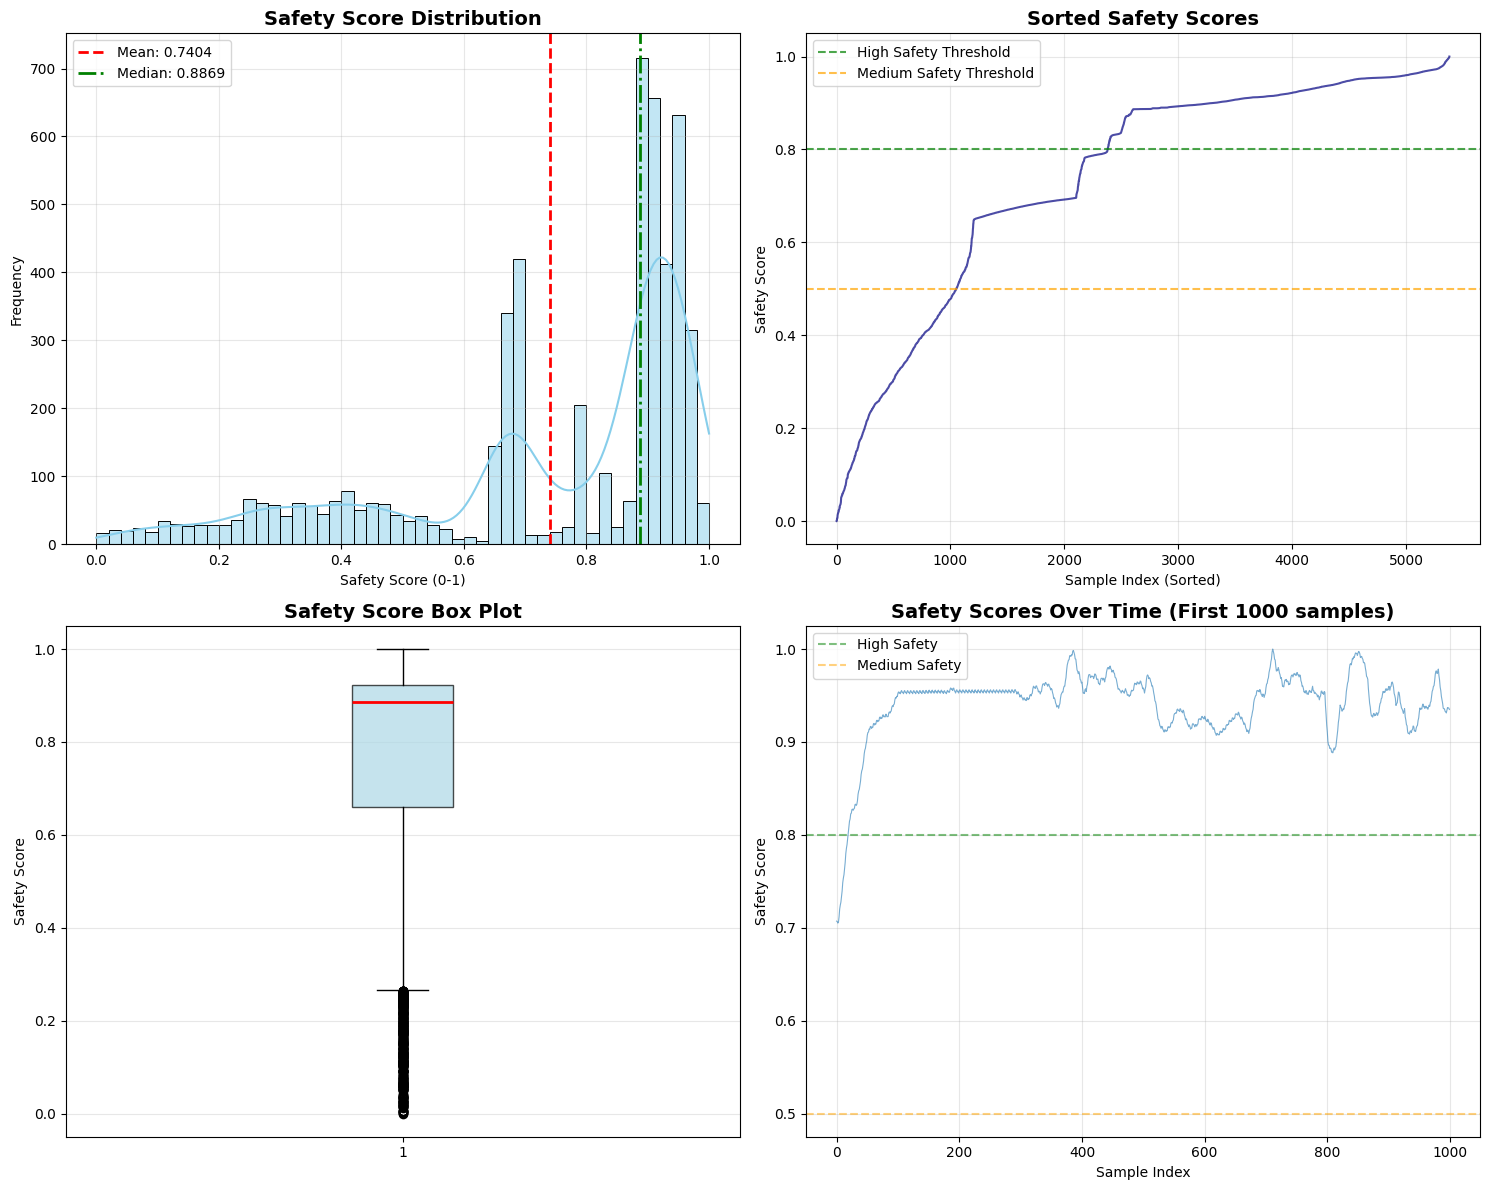


💾 STEP 6: SAVING RESULTS
------------------------------------------------------------
✅ Safety scores saved: /content/drive/MyDrive/federated_learning/server/safety_scores_round_1_20251126_152625.csv
✅ Summary report saved: /content/drive/MyDrive/federated_learning/server/summary_round_1_20251126_152625.txt
✅ Global model saved: /content/drive/MyDrive/federated_learning/server/global_model_round_1_20251126_152625.keras

🎯 SERVER PIPELINE COMPLETED
Round:                  1
Clients Aggregated:     2
Aggregation Method:     FEDAVG
Total Samples Scored:   5,381
Average Safety Score:   0.7404

📁 All results saved to: /content/drive/MyDrive/federated_learning/server/


🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉

              ✅ SERVER AGGREGATION COMPLETED SUCCESSFULLY!            

🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉



In [ ]:
# EXECUTE SERVER PIPELINE
# Specify which clients to aggregate (must have uploaded weights to Google Drive)

CLIENT_IDS = [1, 2]  # Change this to match your client IDs
AGGREGATION_METHOD = 'fedavg'  # Options: 'fedavg' or 'median'

results = run_server_pipeline(
    client_ids=CLIENT_IDS,
    round_num=ROUND_NUM,
    aggregation_method=AGGREGATION_METHOD,
    timesteps=20
)

if results:
    print("\n" + "*"*35)
    print("\n" + "   SERVER AGGREGATION COMPLETED SUCCESSFULLY!".center(70))
    print("\n" + "*"*35 + "\n")
else:
    print("\n Server pipeline failed. Check error messages above.")

In [ ]:
# DISPLAY RESULTS

if results:
    print("\n" + "="*70)
    print(" RESULTS SUMMARY")
    print("="*70)

    print(f"\n Safety Score Statistics:")
    print(f"  Total samples:          {len(results['safety_scores']):,}")
    print(f"  Mean safety score:      {np.mean(results['safety_scores']):.4f}")
    print(f"  Min safety score:       {np.min(results['safety_scores']):.4f}")
    print(f"  Max safety score:       {np.max(results['safety_scores']):.4f}")

    print(f"\n Output Files:")
    print(f"  Global model:           {os.path.basename(results['model_file'])}")
    print(f"  TFLite model:           Aggregator-model.tflite")
    print(f"  Safety scores CSV:      {os.path.basename(results['scores_file'])}")

    # Display sample safety scores
    print(f"\n Sample Safety Scores (first 10):")
    for i in range(min(10, len(results['safety_scores']))):
        print(f"  Sample {i}: {results['safety_scores'][i]:.4f}")

    print("\n" + "="*70)


📊 RESULTS SUMMARY

🔢 Safety Score Statistics:
  Total samples:          5,381
  Mean safety score:      0.7404
  Min safety score:       0.0000
  Max safety score:       1.0000

💾 Output Files:
  Global model:           global_model_round_1_20251126_152625.keras
  TFLite model:           Aggregator-model.tflite
  Safety scores CSV:      safety_scores_round_1_20251126_152625.csv

📋 Sample Safety Scores (first 10):
  Sample 0: 0.7071
  Sample 1: 0.7067
  Sample 2: 0.7050
  Sample 3: 0.7059
  Sample 4: 0.7116
  Sample 5: 0.7200
  Sample 6: 0.7243
  Sample 7: 0.7275
  Sample 8: 0.7336
  Sample 9: 0.7395




######################################################################
#                                                                    #
#         FEDERATED LEARNING SERVER - AGGREGATION & EVALUATION       #
#                      Round: 1 | Clients: [1, 2]                    #
#                                                                    #
######################################################################


📥 STEP 1: LOADING CLIENT WEIGHTS
------------------------------------------------------------
✅ Loaded 20 weight arrays from Client 1
✅ Loaded 20 weight arrays from Client 2

✅ Loaded weights from 2 clients

🔄 STEP 2: AGGREGATING WEIGHTS
------------------------------------------------------------

🔄 AGGREGATING WEIGHTS - FEDAVG
📊 Number of clients: 2
  Layer 0: Averaged 2 clients, Shape: (13, 256)
  Layer 1: Averaged 2 clients, Shape: (64, 256)
  Layer 2: Averaged 2 clients, Shape: (256,)
  Layer 3: Averaged 2 clients, Shape: (64, 232)
  Layer 4: Averaged 2 client

/tmp/ipython-input-3401957178.py:90: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')


✅ Payloads decoded
✅ Features: 13, Samples: 5400
✅ Created 5381 sequences of shape (20, 13)

🏗️ STEP 4: BUILDING GLOBAL MODEL
------------------------------------------------------------


/tmp/ipython-input-3401957178.py:112: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['acceleration'].fillna(0, inplace=True) # Ensure fillna after compute_acceleration


✅ Global model created with aggregated weights
   Architecture: LSTM Autoencoder (3 layers)
   Parameters: 144,829
   Input shape: (20, 13)

🛡️ STEP 5: GENERATING SAFETY SCORES
------------------------------------------------------------

🛡️ GENERATING SAFETY SCORES

📊 Safety Score Statistics:
  Min:    0.0000
  Max:    1.0000
  Mean:   0.7404
  Median: 0.8869
  Std:    0.2489

📈 Safety Categories:
  High Safety (≥0.8):     3000 (55.8%)
  Medium Safety (0.5-0.8):   1331 (24.7%)
  Low Safety (<0.5):      1050 (19.5%)


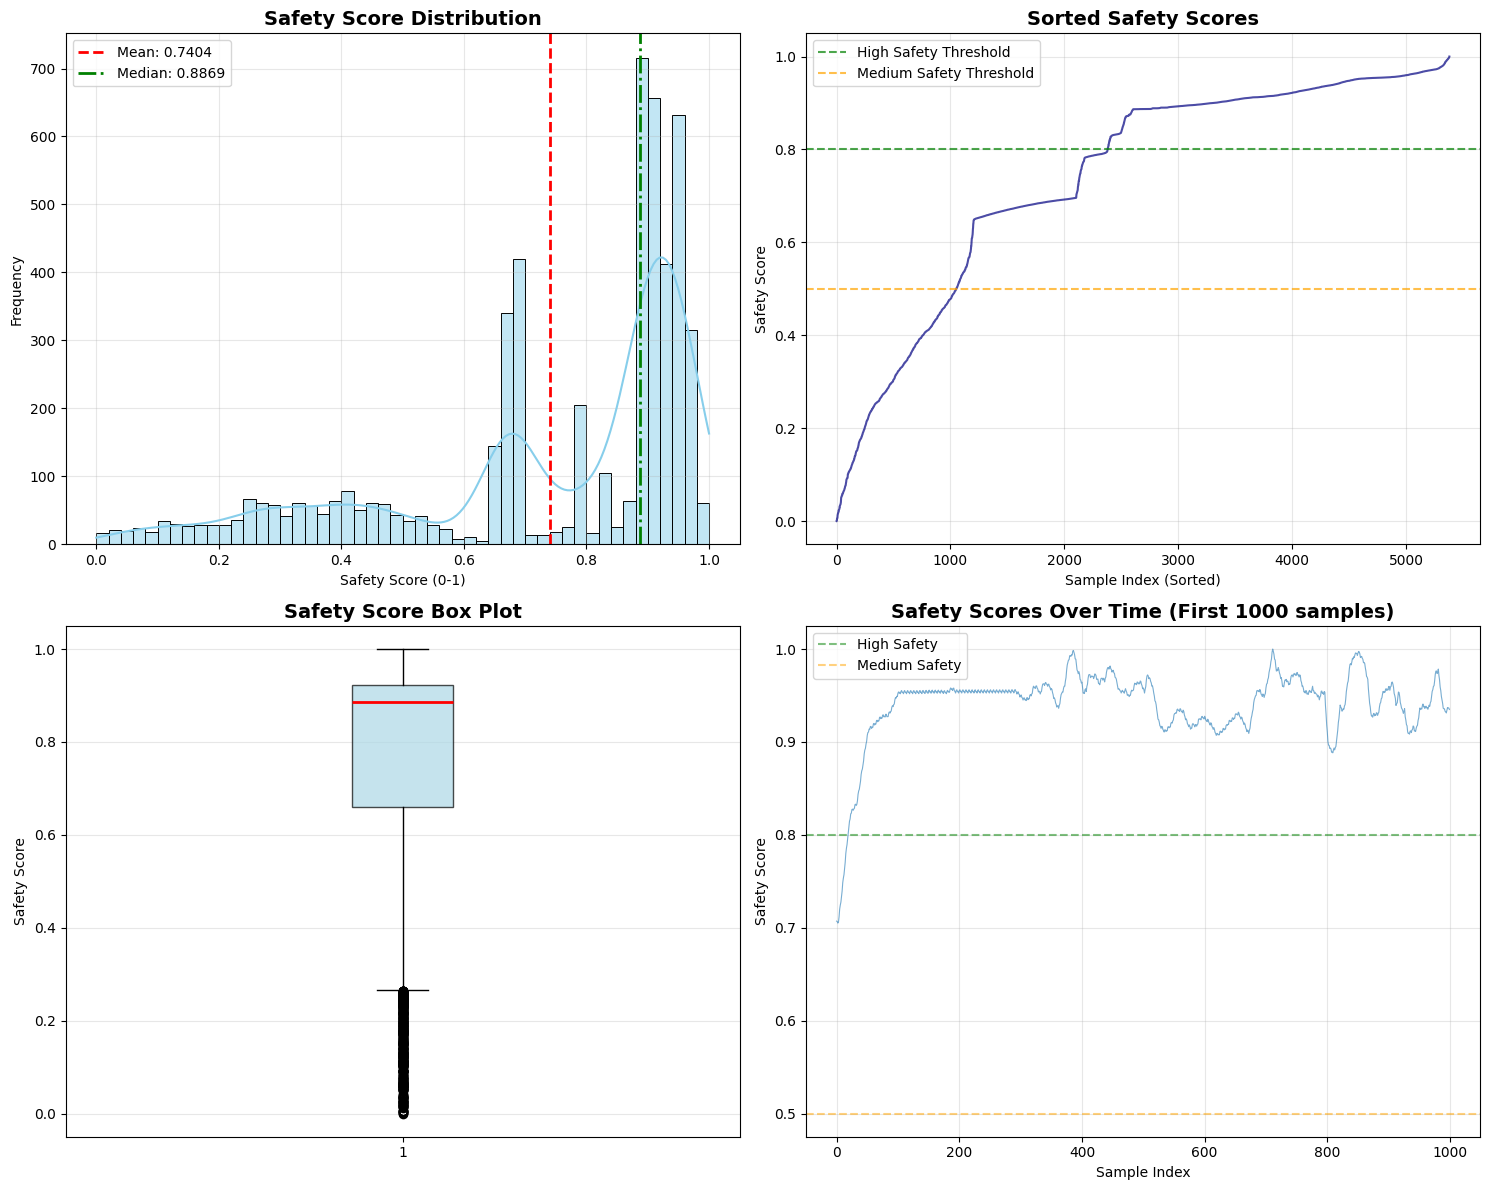


💾 STEP 6: SAVING RESULTS
------------------------------------------------------------
✅ Safety scores saved: /content/drive/MyDrive/federated_learning/server/safety_scores_round_1_20251126_152831.csv
✅ Summary report saved: /content/drive/MyDrive/federated_learning/server/summary_round_1_20251126_152831.txt
✅ Global model saved: /content/drive/MyDrive/federated_learning/server/global_model_round_1_20251126_152831.keras

🎯 SERVER PIPELINE COMPLETED
Round:                  1
Clients Aggregated:     2
Aggregation Method:     FEDAVG
Total Samples Scored:   5,381
Average Safety Score:   0.7404

📁 All results saved to: /content/drive/MyDrive/federated_learning/server/


🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉

              ✅ SERVER AGGREGATION COMPLETED SUCCESSFULLY!            

🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉



In [ ]:
# EXECUTE SERVER PIPELINE
# Specify which clients to aggregate (must have uploaded weights to Google Drive)

CLIENT_IDS = [1, 2]  # Change this to match your client IDs
AGGREGATION_METHOD = 'fedavg'  # Options: 'fedavg' or 'median'

results = run_server_pipeline(
    client_ids=CLIENT_IDS,
    round_num=ROUND_NUM,
    aggregation_method=AGGREGATION_METHOD,
    timesteps=20
)

if results:
    print("\n" + ""*35)
    print("\n" + "   SERVER AGGREGATION COMPLETED SUCCESSFULLY!".center(70))
    print("\n" + ""*35 + "\n")
else:
    print("\n Server pipeline failed. Check error messages above.")

In [ ]:
# DISPLAY RESULTS

if results:
    print("\n" + "="*70)
    print(" RESULTS SUMMARY")
    print("="*70)

    print(f"\n Safety Score Statistics:")
    print(f"  Total samples:          {len(results['safety_scores']):,}")
    print(f"  Mean safety score:      {np.mean(results['safety_scores']):.4f}")
    print(f"  Min safety score:       {np.min(results['safety_scores']):.4f}")
    print(f"  Max safety score:       {np.max(results['safety_scores']):.4f}")

    print(f"\n Output Files:")
    print(f"  Global model:           {os.path.basename(results['model_file'])}")
    print(f"  TFLite model:           Aggregator-model.tflite")
    print(f"  Safety scores CSV:      {os.path.basename(results['scores_file'])}")

    # Display sample safety scores
    print(f"\n Sample Safety Scores (first 10):")
    for i in range(min(10, len(results['safety_scores']))):
        print(f"  Sample {i}: {results['safety_scores'][i]:.4f}")

    print("\n" + "="*70)


📊 RESULTS SUMMARY

🔢 Safety Score Statistics:
  Total samples:          5,381
  Mean safety score:      0.7404
  Min safety score:       0.0000
  Max safety score:       1.0000

💾 Output Files:
  Global model:           global_model_round_1_20251126_152831.keras
  TFLite model:           Aggregator-model.tflite
  Safety scores CSV:      safety_scores_round_1_20251126_152831.csv

📋 Sample Safety Scores (first 10):
  Sample 0: 0.7071
  Sample 1: 0.7067
  Sample 2: 0.7050
  Sample 3: 0.7059
  Sample 4: 0.7116
  Sample 5: 0.7200
  Sample 6: 0.7243
  Sample 7: 0.7275
  Sample 8: 0.7336
  Sample 9: 0.7395



In [ ]:
# OPTIONAL: Download results to local machine

if results:
    print("\n Downloading server results to local machine...\n")

    try:
        # Define the TFLite model path
        tflite_model_file = f"{SERVER_OUTPUT}/Aggregator-model.tflite"

        # Convert the global model to TFLite
        converter = tf.lite.TFLiteConverter.from_keras_model(results['global_model'])
        # Apply the suggested fix for dynamic shapes/tensor list ops
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
        converter._experimental_lower_tensor_list_ops = False

        tflite_model = converter.convert()

        # Save the TFLite model
        with open(tflite_model_file, 'wb') as f:
            f.write(tflite_model)
        print(f" TFLite model saved: {tflite_model_file}")

        # Update results dictionary with tflite_file path
        results['tflite_file'] = tflite_model_file

        # Download TFLite model
        if results['tflite_file'] and os.path.exists(results['tflite_file']):
            files.download(results['tflite_file'])
            print(f"Downloaded: Aggregator-model.tflite")

        # Download global model
        files.download(results['model_file'])
        print(f" Downloaded: {os.path.basename(results['model_file'])}")

        # Download safety scores
        files.download(results['scores_file'])
        print(f" Downloaded: {os.path.basename(results['scores_file'])}")

        print("\n All server results downloaded successfully!")
    except Exception as e:
        print(f" Download or TFLite conversion error: {e}")
        print("  Files are still available in Google Drive")


📥 Downloading server results to local machine...

Saved artifact at '/tmp/tmp0g_va2qm'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 20, 13), dtype=tf.float32, name='can_input')
Output Type:
  TensorSpec(shape=(None, 20, 13), dtype=tf.float32, name=None)
Captures:
  132385668126224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132385668124688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132385668124304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132388274834320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132385700531472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132385687460496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132385668124880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132385668121808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132385698530896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132385698530704: TensorSpec(shape=()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded: Aggregator-model.tflite


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded: global_model_round_1_20251126_152831.keras


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded: safety_scores_round_1_20251126_152831.csv

✅ All server results downloaded successfully!


In [ ]:
# OPTIONAL: Download results to local machine

if results:
    print("\n Downloading server results to local machine...\n")

    try:
        # Download TFLite model
        if results['tflite_file'] and os.path.exists(results['tflite_file']):
            files.download(results['tflite_file'])
            print(f" Downloaded: Aggregator-model.tflite")

        # Download global model
        files.download(results['model_file'])
        print(f" Downloaded: {os.path.basename(results['model_file'])}")

        # Download safety scores
        files.download(results['scores_file'])
        print(f" Downloaded: {os.path.basename(results['scores_file'])}")

        print("\n All server results downloaded successfully!")
    except Exception as e:
        print(f" Download error: {e}")
        print("  Files are still available in Google Drive")


📥 Downloading server results to local machine...

⚠️ Download error: 'tflite_file'
  Files are still available in Google Drive
